In [1]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import sqlite3 as lite
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
%matplotlib inline
from collections import Counter
import itertools

In [2]:
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/43.0.2357.124 Safari/537.36'}

In [3]:
cities = [['tx', "austin"] ,[ 'ca' , 'los-angeles'] ,[ 'ga' , 'atlanta'] ,[ 'ma' , 'boston'] ,[ 'nc' , 'charlotte'] ,[ 'tx' , 'dallas'] ,[ 'co' , 'denver'] ,[ 'tx' , 'houston'] ,[ 'fl' , 'miami'] ,[ 'mn' , 'minneapolis'] ,[ 'ny' , 'new-york'] ,[ 'pa' , 'philadelphia'] ,[ 'az' , 'phoenix'] ,[ 'or' , 'portland'] ,[ 'ca' , 'san-francisco'] ,[ 'ca' , 'san-diego'] ,[ 'wa' , 'seattle'] ,[ 'dc' , 'washington'] ]

In [4]:
# CRAWL ALL THE PAGES OF INTERST
datadir = 'crawl/'
if not(os.path.isdir(datadir)):
    os.makedirs(datadir)

for city in cities:
    k = city[0]
    v = city[1]
    running = True
    page = 1
    print ''
    print k,v
    while running:
        url = "https://dogvacay.com/dog-boarding--" + k + "--" + v + "?p="+str(page)
        filename = datadir + k + '-' + v + '-' + str(page) + '.htm'
        if not(os.path.isfile(filename)):
            sys.stdout.write('-')
            r = requests.get(url, headers=headers)
            time.sleep(1)
            f = open(filename, 'w')
            f.write(r.text.encode('ascii', 'replace'))
            f.close()
            data = r.text
        else:
            sys.stdout.write('.')
            f = open(filename, 'r')
            data = f.read()
            f.close()
        soup = BeautifulSoup(data)
        pagination_links = soup.findAll('a', {'class': 'pagination-link'})
        running = False
        for pl in pagination_links:
            if pl.text.find('Next') == 0:
                running = True
        page+=1



tx austin
.........
ca los-angeles
........................................................
ga atlanta
............
ma boston
.............
nc charlotte
.......
tx dallas
............
co denver
...........
tx houston
...........
fl miami
.........
mn minneapolis
.......
ny new-york
...............................................................
pa philadelphia
............
az phoenix
.........
or portland
..........
ca san-francisco
.............................
ca san-diego
............
wa seattle
..........
dc washington
...........................

In [5]:
# Data extraction phase

times = []
fees = []
reviews = []
repeats = []
city = []
service = []
rating = []
name = []


for src in os.listdir(datadir):
    filename = datadir + src
    print 'Processing: ' + filename
    f = open(filename, 'r')
    data = f.read()
    f.close()
    soup = BeautifulSoup(data)
    sitters = soup.findAll('div', {'class': 'card-content'})
    for sitter in sitters:
        rtwrap = sitter.findAll('div', {'class': 'icon-wrapper'})
        if len(rtwrap) > 0:
            response_time = rtwrap[0].text.strip('\n')[19:]
        else:
            response_time = -1
        fee = sitter.findAll('div', {'class': 'price price--primary u-text-center'})
        review = sitter.find('span', {'class': 'vcard-review'})
        if review is not None and len(review) > 0:
            review = int(review.text.replace('Reviews', '').replace('Review', '').strip())
        else:
            review = 0
        repeat = sitter.findAll('div', {'class': 'icon-wrapper'})
        if len(repeat) == 2 and len(repeat[1].text.strip()) > 12:
            repeat = repeat[1].text.strip()[:2]
        else:
            repeat = 0
        services = sitter.findAll('div', {'class': 'vcard-line-item'})
        full_star = sitter.findAll('i', {'class': 'ck-star'})
        ratings = len(full_star)
        half_star = sitter.findAll('i', {'class': 'ck-star-half'})
        if len(half_star) > 0:
            ratings += .5
        names = sitter.find('h2', {'class': 'vcard-title'}).text.strip('\n$')#.split(' ')
        fees.append(fee[0].text.strip('\n$')[:2])
        title = soup.find('title').text
        i = title.find(' Dog Boarding')
        title = title[0:i]
        city.append(title)
        times.append(response_time)
        reviews.append(review)
        repeats.append(repeat)
        service.append(services[-1].text.strip('\n'))
        rating.append(ratings)
        name.append(names)

df = pd.DataFrame({'city': city, 'fee': fees, 'response_time': times, 'review' : reviews, 'repeat' : repeats, 'services' : service, 'ratings': rating, 'names': name})

Processing: crawl/az-phoenix-1.htm
Processing: crawl/az-phoenix-2.htm
Processing: crawl/az-phoenix-3.htm
Processing: crawl/az-phoenix-4.htm
Processing: crawl/az-phoenix-5.htm
Processing: crawl/az-phoenix-6.htm
Processing: crawl/az-phoenix-7.htm
Processing: crawl/az-phoenix-8.htm
Processing: crawl/az-phoenix-9.htm
Processing: crawl/ca-los-angeles-1.htm
Processing: crawl/ca-los-angeles-10.htm
Processing: crawl/ca-los-angeles-11.htm
Processing: crawl/ca-los-angeles-12.htm
Processing: crawl/ca-los-angeles-13.htm
Processing: crawl/ca-los-angeles-14.htm
Processing: crawl/ca-los-angeles-15.htm
Processing: crawl/ca-los-angeles-16.htm
Processing: crawl/ca-los-angeles-17.htm
Processing: crawl/ca-los-angeles-18.htm
Processing: crawl/ca-los-angeles-19.htm
Processing: crawl/ca-los-angeles-2.htm
Processing: crawl/ca-los-angeles-20.htm
Processing: crawl/ca-los-angeles-21.htm
Processing: crawl/ca-los-angeles-22.htm
Processing: crawl/ca-los-angeles-23.htm
Processing: crawl/ca-los-angeles-24.htm
Process

In [6]:
df.head()

,city,fee,names,ratings,repeat,response_time,review,services
0,"Phoenix, Arizona",35,Big Backyard in Central Phoenix,5,8,Few Hours,26,Boarding and Daycare
1,"Phoenix, Arizona",35,SUZY Q to the Rescue,5,16,Day,30,"Boarding, Checkups and Visits, and Pick up and..."
2,"Phoenix, Arizona",35,24/7 Dog boarding,0,0,Few Hours,0,"Boarding, Daycare, Checkups and Visits, Walkin..."
3,"Phoenix, Arizona",38,Messy4dogs@gmail.com,5,2,Few Days,3,"Boarding, Daycare, Checkups and Visits, Walkin..."
4,"Phoenix, Arizona",25,Pet Paradise,5,1,Few Hours,5,"Boarding, Checkups and Visits, Walking, and Ba..."


In [7]:
#eliminate trailing spaces from response_time
df['response_time'] = df['response_time'].apply(lambda x: str(x).strip())

In [8]:
#separate services
df['boarding'] = df['services'].map(lambda x: 1 if "Boarding" in x else 0)
df['sitting'] = df['services'].map(lambda x: 1 if "Sitting" in x else 0)
df['daycare'] = df['services'].map(lambda x: 1 if "Daycare" in x else 0)
df['checkups'] = df['services'].map(lambda x: 1 if "Checkups and Visits" in x else 0)
df['walking'] = df['services'].map(lambda x: 1 if "Walking" in x else 0)
df['bathing'] = df['services'].map(lambda x: 1 if "Bathing" in x else 0)
df['training'] = df['services'].map(lambda x: 1 if "Training" in x else 0)
df['grooming'] = df['services'].map(lambda x: 1 if "Grooming" in x else 0)
df['pickup/dropoff'] = df['services'].map(lambda x: 1 if "Pick up and Drop off" in x else 0)

In [9]:
#response time
df['response_time'] = df['response_time'].map(lambda x: 1 if x == 'Few Hours' else 2 if x == 'Day' else 3)

In [10]:
df.ix[df['fee']=='', 'fee'] = 0

In [11]:
df["fee"] = df["fee"].astype(float)
df["repeat"] = df["repeat"].astype(int)

In [12]:
df['services'] = df['boarding']+df['sitting']+df['daycare']+df['checkups']+df['walking']+df['bathing']+df['training']+df['grooming']+df['pickup/dropoff']

In [13]:
df.head()

,city,fee,names,ratings,repeat,response_time,review,services,boarding,sitting,daycare,checkups,walking,bathing,training,grooming,pickup/dropoff
0,"Phoenix, Arizona",35,Big Backyard in Central Phoenix,5,8,1,26,2,1,0,1,0,0,0,0,0,0
1,"Phoenix, Arizona",35,SUZY Q to the Rescue,5,16,2,30,3,1,0,0,1,0,0,0,0,1
2,"Phoenix, Arizona",35,24/7 Dog boarding,0,0,1,0,4,1,0,1,1,1,0,0,0,0
3,"Phoenix, Arizona",38,Messy4dogs@gmail.com,5,2,3,3,4,1,0,1,1,1,0,0,0,0
4,"Phoenix, Arizona",25,Pet Paradise,5,1,1,5,4,1,0,0,1,1,1,0,0,0


In [14]:
# SAVE TO CSV FILE
df.to_csv('dog-vacay.csv', encoding='ascii')

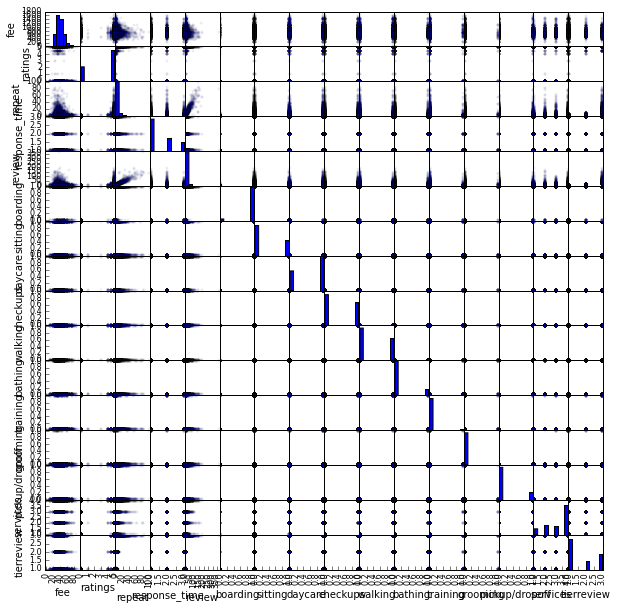

In [141]:
#Create a scatter plot matrix
a = pd.scatter_matrix(df, alpha=.05, figsize=(10,10))
plt.show()

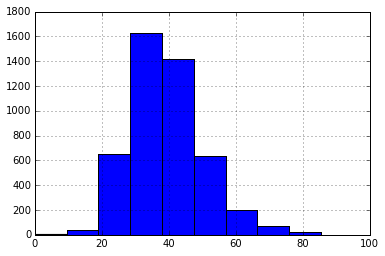

In [72]:
#Histogram of fees
p = df['fee'].hist()
plt.show()

In [77]:
#Extract columns
fee = df['fee']
repeat = df['repeat']
ratings = df['ratings']

In [78]:
#The dependent variable
y = np.matrix(fee).transpose()
#The independent variable
x1 = np.matrix(repeat).transpose()
x2 = np.matrix(rating).transpose()

In [79]:
x = np.column_stack([x1, x2])

In [80]:
X = sm.add_constant(x)
model = sm.OLS(y,X)
f = model.fit()
f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     46.77
Date:                Sun, 13 Sep 2015   Prob (F-statistic):           7.72e-21
Time:                        21:05:33   Log-Likelihood:                -17825.
No. Observations:                4662   AIC:                         3.566e+04
Df Residuals:                    4659   BIC:                         3.568e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         40.7037      0.290    140.482      0.000        40.136    41.272
x1            -0.0858      0.018     -4.744      0.000        -0.121    -0.050
x2            -0.4718      0.075     -6.314      0.000        -0.618    -0.325
==============================================================================
Omnibus:                      510.384   Durbin-Watson:                   1.564
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              843.641
Skew:                           0.768   Prob(JB):                    6.39e-184
Kurtosis:                       4.408   Cond. No.                         20.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [125]:
#df.groupby('repeat').mean()

In [124]:
#df.groupby('repeat').median()

In [123]:
#df.groupby('services').median()

In [122]:
#df.groupby('services').mean()

In [117]:
#df.groupby('review').median()

In [118]:
#atx.groupby('review').median()

In [119]:
#sea.groupby('review').median()

In [183]:
#df.groupby('city').mean()

In [184]:
#df.groupby('city').median()